# PyTorch Intro
PyTorch Official Tutorial: https://pytorch.org/tutorials/

This file will be uploaded to the Homework repository.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

import pdb

In [2]:
import loader # a module (.py file) we created. Read for more information

basic_transform = transforms.Compose([transforms.ToTensor()])

batch_size = 32

trainloader, validloader = loader.get_data_loader(basic_transform, 
                                                  basic_transform, 
                                                  batch_size)


torch.Size([32, 3, 30, 30])
torch.Size([32])
tensor([4, 1, 0, 4, 2, 2, 3, 0, 0, 1, 2, 0, 4, 0, 3, 3, 2, 0, 2, 4, 4, 1, 2, 1,
        2, 0, 4, 1, 3, 1, 2, 1])


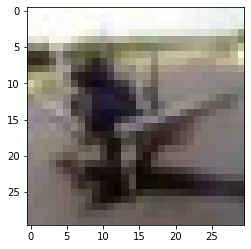

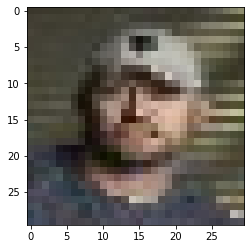

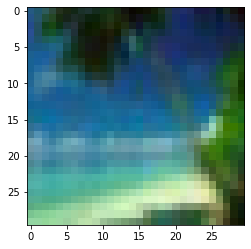

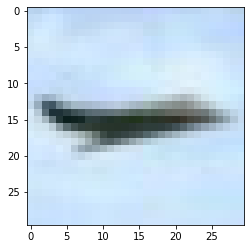

In [3]:
# [32, 3, 30, 30] = [batch size, channels, height, width]
for x, y in trainloader:
    print(x.shape)
    print(y.shape)
    print(y)
    break

# vis
for i in range(4):
    plt.imshow(np.transpose(x[i,:], (1,2,0))) # 30 x 30 x 3
    plt.show()


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # define the layers
        # kernel size = 3 means (3,3) kernel
        # rgb -> 3 -> in channel
        # number of feature maps = 16
        # number of kernel parameters = out_channels x in_channels x kernel_size x kernel_size
        self.l1 = nn.Conv2d(kernel_size=3, in_channels=3, out_channels=16)
        
        # MaxPool2d, AvgPool2d. 
        # The first 2 = 2x2 kernel size, 
        # The second 2 means the stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.l2 = nn.Conv2d(kernel_size=3, in_channels=16, out_channels=32)
        
        # FC layer
        self.fc1 = nn.Linear(32 * 6 * 6, 5) # IMPORTANT ! 
        # 32 (channels) * heigth in out (6) * width in out (6)
        
    def forward(self, x):
        # define the data flow through the deep learning layers
        
        # x = self.l1(x)
        # x = F.relu(x)
        # x = self.pool(x)
        # These three lines above will be equivalent to the following line

        # 32 x 3 x 30 x 30 -> 32 x 16 x 28 x 28
        x = self.pool(F.relu(self.l1(x))) # bs x 16 x 14 x 14. Width 30 ->(conv) 28 ->(pool) 14
        x = self.pool(F.relu(self.l2(x))) # bs x 32 x 6 x 6. Width 14 -> (conv) 12 -> (pool) 6
        # print(x.shape)
        x = x.reshape(-1, 32*6*6) # [bs x 1152]# CRUCIAL!
        # print(x.shape)
        x = self.fc1(x) # bs x 5
        return x

In [6]:
m = CNN()
pred = m(x) # x is one batch of data [32, 3, 30, 30]
# pred is [32, 5] because we have 32 images and 5 classes
print(pred.shape)

torch.Size([32, 5])


In [7]:
print(pred)
print(torch.softmax(pred, dim=1))

tensor([[ 8.2618e-02, -6.8853e-02,  9.1328e-03, -1.2301e-02, -1.6066e-02],
        [ 1.3201e-01, -1.2137e-02,  5.2223e-02, -3.1478e-02,  1.1403e-02],
        [ 6.9849e-02, -1.2751e-02,  1.8858e-03, -1.2186e-02,  3.7438e-02],
        [ 5.6346e-02, -1.2808e-01, -2.5961e-02,  1.2094e-02,  7.5650e-02],
        [ 1.1275e-01, -9.7736e-02,  6.1103e-03, -1.7545e-02, -3.0729e-02],
        [ 4.1301e-02, -1.0539e-01, -1.8029e-02,  6.7402e-03, -4.6212e-02],
        [ 1.3031e-01, -2.3085e-02,  1.9058e-02,  5.8588e-03, -1.5414e-02],
        [ 1.0583e-01, -4.9403e-02, -3.1325e-03, -1.2749e-02, -2.1001e-02],
        [ 9.0726e-02, -5.9389e-02,  1.8372e-02, -2.4305e-02,  1.6763e-02],
        [ 7.4221e-02, -1.0608e-01, -1.2887e-02,  1.3234e-02,  3.3972e-02],
        [ 1.2493e-01, -1.8027e-02, -1.3269e-02, -1.4148e-02, -4.6445e-06],
        [ 6.7382e-02, -1.6463e-02,  2.1272e-02, -2.2794e-02,  6.7707e-04],
        [ 7.1748e-02, -4.3012e-02,  1.7897e-02,  1.5478e-02,  2.9221e-02],
        [ 5.1605e-02, -7.

# Training

In [8]:
criterion = nn.CrossEntropyLoss()
num_epoches = 3 # give me a number from 2-5
import tqdm

import torch.optim as optim


USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    m = m.cuda()

In [9]:
for epoch_id in range(num_epoches):
    optimizer = optim.SGD(m.parameters(), lr=0.01 * 0.95 ** epoch_id)
    for x, y in tqdm.tqdm(trainloader):
        if USE_CUDA:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad() # clear (reset) the gradient for the optimizer
        pred = m(x) # forward pass, will call forward(self, x) function.
        loss = criterion(pred, y)
        loss.backward() # Backward pass: calculating the gradient
        optimizer.step() # Updating the Parameters in backpropagation: optimize the model

100%|██████████| 391/391 [00:08<00:00, 45.14it/s]


# Testing

In [10]:
all_gt = []
all_pred = []

for x, y in tqdm.tqdm(validloader):
    if USE_CUDA:
        x, y = x.cuda(), y.cuda()
    all_gt += list(y.detach().cpu().numpy().reshape(-1))
    pred = torch.argmax(m(x), dim=1)
    all_pred += list(pred.detach().cpu().numpy().reshape(-1))
    
    

100%|██████████| 79/79 [00:02<00:00, 33.64it/s]


In [11]:
print(all_gt)
print(all_pred)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [12]:
acc = np.sum(np.array(all_gt) == np.array(all_pred)) / len(all_gt)
print("Accuracy is:", acc)

Accuracy is: 0.6788
